In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

In [6]:
!unzip -q "/kaggle/input/dogs-vs-cats/test1.zip"
!unzip -q "/kaggle/input/dogs-vs-cats/train.zip"

In [38]:
# 全局变量
SEED = 19260817
TRAIN_PATH = '../working/train'
TEST_PATH = '../working/test1'
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 128

if torch.cuda.is_available():
    print("Using cuda.")
    DEVICE = 'cuda:0'
else:
    print("Using cpu.")
    DEVICE = 'cpu'
    
MODEL_PATH = 'model/'

Using cpu.


In [4]:
# manual_seed
torch.manual_seed(SEED)

In [8]:
# 截取标签
labels_list = []
train_imgs = os.listdir(TRAIN_PATH)

for f in train_imgs:

    # 0 for 'cat', 1 for 'dog'
    if f.split('.')[0] == 'cat':
        labels_list.append(0)

    elif f.split('.')[0] == 'dog':
        labels_list.append(1)

    else:
    # if no label
        labels_list.append(-1)

print(f'Images count = {len(train_imgs)}\nLabels count = {len(labels_list)}')

Images count = 25000
Labels count = 25000


In [9]:
df_train = pd.DataFrame(columns= ['image', 'label'])
df_train['image'] = train_imgs
df_train['label'] = labels_list

df_train.head(3)

,image,label
0,dog.7493.jpg,1
1,cat.12450.jpg,0
2,dog.117.jpg,1


In [9]:
TOTAL_MEAN = np.zeros((1, 3))
TOTAL_STD = np.zeros((1, 3))
for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata())
        TOTAL_MEAN += np.mean(img_np, axis=0)
        TOTAL_STD += np.std(img_np, axis=0)
TOTAL_MEAN /= df_train.shape[0] * 255
TOTAL_STD /= df_train.shape[0] * 255

In [10]:
print(f"Red ch mean   = {TOTAL_MEAN[0, 0]}\nGreen ch mean = {TOTAL_MEAN[0, 1]}\nBlue ch mean  = {TOTAL_MEAN[0, 2]}")
print(f"Red ch std    = {TOTAL_STD[0, 0]}\nGreen ch std  = {TOTAL_STD[0, 1]}\nBlue ch std   = {TOTAL_STD[0, 2]}")

Red ch mean   = 0.4883204374097933
Green ch mean = 0.4550763779268362
Blue ch mean  = 0.4169608295891623
Red ch std    = 0.22954217038433467
Green ch std  = 0.22502466727814585
Blue ch std   = 0.22531743066677506


In [10]:
class DogsCatsDataset(Dataset):
    def __init__(self, x, y, transform=None, submission=False):
        self.x = x.reset_index()
        self.y = y.reset_index()
        self.submission = submission
        self.transform = transform

    def __len__(self):
        return self.x.shape[0]

    def load_image(self, path):
        prefix = TRAIN_PATH
        if self.submission:
            prefix = TEST_PATH
        #return np.array(Image.open(os.path.join(prefix, path)))
        return Image.open(os.path.join(prefix, path['image']))

    def __getitem__(self, index):
        image = self.load_image(self.x.iloc[index])
        label = self.y.iloc[index]['label']
        if self.transform:
            image = self.transform(image)
        if self.submission:
            image = np.array(image)
        data = {'image': image, 'label': label}
        return data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_train['image'], df_train['label'], test_size= 0.2, random_state= SEED, stratify= df_train['label'])
print(f'Train size = {X_train.shape[0]}\nTest size = {X_test.shape[0]}')

Train size = 20000
Test size = 5000


In [29]:
train_transforms = transforms.Compose(
    [transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    #transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
    transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])])

test_transforms =  transforms.Compose(
    [transforms.Resize((128, 128)),
    transforms.ToTensor(), 
    #transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
    transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])])

In [30]:
train_data = DogsCatsDataset(X_train, y_train, transform= train_transforms)
test_data = DogsCatsDataset(X_test, y_test, transform= test_transforms)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, num_workers=2)

In [31]:
train_data = DogsCatsDataset(X_train, y_train, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=4)

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    if i_batch > 4:
        break

0 torch.Size([32, 3, 128, 128]) torch.Size([32])
1 torch.Size([32, 3, 128, 128]) torch.Size([32])
2 torch.Size([32, 3, 128, 128]) torch.Size([32])
3 torch.Size([32, 3, 128, 128]) torch.Size([32])
4 torch.Size([32, 3, 128, 128]) torch.Size([32])
5 torch.Size([32, 3, 128, 128]) torch.Size([32])


In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(57600, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

model = ConvNet()

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [34]:
def train(model, train_loader, optimizer, criterion, n_epochs, p_step):
    model.train()
    model.to(DEVICE)
    total_loss = 0
    loss_list = []
    acc_list = []
    for epoch in range(n_epochs):
        for step, batched in enumerate(train_loader):
            data = batched['image']
            target = batched['label']
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if step % p_step == 0:
                pred = torch.argmax(output, dim=1)
                correct = pred.eq(target)
                acc = torch.mean(correct.float())
                acc = acc.to('cpu')
                print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, n_epochs, step, total_loss/p_step, acc))
                loss_list.append(total_loss/p_step)
                acc_list.append(acc)
                total_loss = 0
    plt.plot(loss_list[1:], label='loss')
    plt.plot(acc_list[1:], label='accuracy')
    plt.legend()
    plt.title('training loss and accuracy')
    plt.show()
    print('Finished Training')

[Epoch 1/1] Iteration 0 -> Train Loss: 0.0139, Accuracy: 0.469
[Epoch 1/1] Iteration 50 -> Train Loss: 0.6934, Accuracy: 0.625
[Epoch 1/1] Iteration 100 -> Train Loss: 0.6933, Accuracy: 0.406
[Epoch 1/1] Iteration 150 -> Train Loss: 0.6930, Accuracy: 0.375
[Epoch 1/1] Iteration 200 -> Train Loss: 0.6930, Accuracy: 0.406
[Epoch 1/1] Iteration 250 -> Train Loss: 0.6932, Accuracy: 0.531
[Epoch 1/1] Iteration 300 -> Train Loss: 0.6931, Accuracy: 0.438
[Epoch 1/1] Iteration 350 -> Train Loss: 0.6932, Accuracy: 0.500
[Epoch 1/1] Iteration 400 -> Train Loss: 0.6931, Accuracy: 0.500
[Epoch 1/1] Iteration 450 -> Train Loss: 0.6930, Accuracy: 0.375
[Epoch 1/1] Iteration 500 -> Train Loss: 0.6930, Accuracy: 0.500
[Epoch 1/1] Iteration 550 -> Train Loss: 0.6933, Accuracy: 0.625
[Epoch 1/1] Iteration 600 -> Train Loss: 0.6930, Accuracy: 0.625


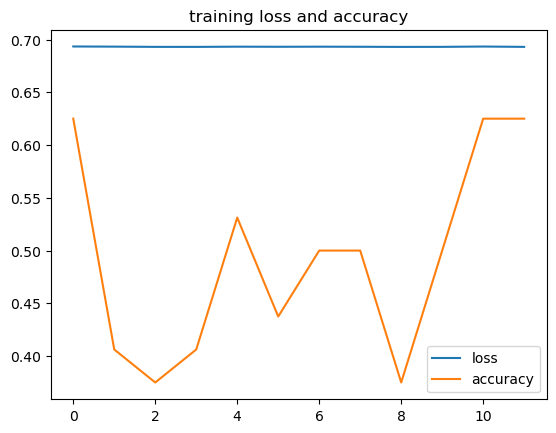

Finished Training


In [37]:
train(model, train_loader, optimizer, criterion, 1, 50)

In [41]:
if not os.path.exists(os.path.join('../working/', MODEL_PATH)):
    os.makedirs(os.path.join('../working/', MODEL_PATH))

torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'ConvNet.pt'))

# TO LOAD:
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

In [47]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    acc_list = []
    loss_list = []
    with torch.no_grad():
        for batched in tqdm(test_loader):
            data = batched['image']
            target = batched['label']
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(target)
            acc = torch.mean(correct.float())
            acc = acc.to('cpu')
            acc_list.append(acc)
            loss = loss.to('cpu')
            loss_list.append(loss)
    print(f'Mean acc = {np.mean(acc_list): .3f}. Mean loss = {np.mean(loss_list): .3f}')

In [48]:
%%time
print('Self-made ConvNet:')
test(model, test_loader, criterion)

Self-made ConvNet:


100%|██████████| 40/40 [00:54<00:00,  1.37s/it]

Mean acc =  0.495. Mean loss =  0.693
CPU times: user 1min 4s, sys: 39.8 s, total: 1min 44s
Wall time: 54.8 s
